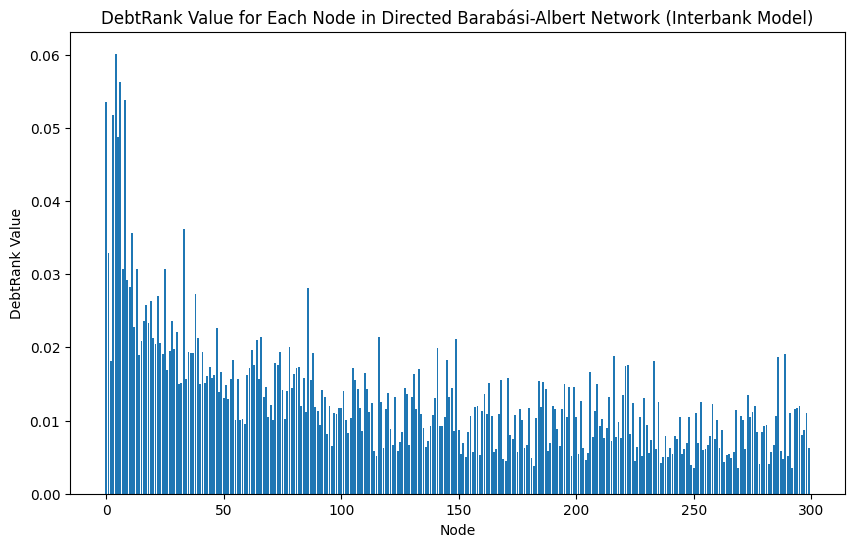

In [36]:
# Re-import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt

# Recreate a Barabási-Albert network with directed edges
G = nx.barabasi_albert_graph(300, 3)  # 50 nodes, each new node attaches to 3 existing nodes

# Step 1: Convert to a fully directed network by duplicating each edge with reversed direction
G_directed = nx.DiGraph()
G_directed.add_nodes_from(G.nodes())

# For each edge in the undirected network, create a directed edge in both directions
for u, v in G.edges():
    G_directed.add_edge(u, v, W_ij=0.1)  # original direction
    G_directed.add_edge(v, u, W_ij=0.1)  # reverse direction

# Step 2: Calculate each node's `v_j` as its share of total network investment
total_investment = sum([G_directed.edges[u, v]['W_ij'] for u, v in G_directed.edges()])
for node in G_directed.nodes():
    node_investment = sum([G_directed.edges[node, neighbor]['W_ij'] for neighbor in G_directed.successors(node)])
    G_directed.nodes[node]['v_j'] = node_investment / total_investment if total_investment > 0 else 0

# Re-define DebtRank function adapted for directed graphs
def debt_rank_directed(G, S_f, y=1.0):
    h, s = {}, {}
    T = 0
    nodes = G.nodes()
    for i in nodes:
        h[i] = [0]
        s[i] = ['D' if i in S_f else 'U']
        if i in S_f:
            h[i][0] = y

    W_in = {i: [(j, G.edges[j, i]['W_ij']) for j in G.predecessors(i)] for i in nodes}
    active = True
    while active:
        T += 1
        active = False
        h_t, s_t = {}, {}
        for i in nodes:
            sum_impact = sum([W_ji * h[j][T - 1] for (j, W_ji) in W_in[i] if s[j][T - 1] == 'D'])
            h_i_t = min(1.0, h[i][T - 1] + sum_impact)
            h_t[i] = h_i_t
            if h_i_t > h[i][T - 1]:
                active = True
        for i in nodes:
            s_t[i] = 'I' if s[i][-1] == 'D' else 'D' if h_t[i] > 0 and s[i][-1] != 'I' else s[i][-1]
            if s_t[i] == 'D':
                active = True
        for i in nodes:
            h[i].append(h_t[i])
            s[i].append(s_t[i])

    v = nx.get_node_attributes(G, 'v_j')
    R = sum([h[i][-1] * v[i] for i in nodes]) - sum([h[i][0] * v[i] for i in nodes])
    return R, h, s, T

# Run DebtRank for each node as S_f and store results
debtrank_values_directed = {}
for node in G_directed.nodes():
    R, _, _, _ = debt_rank_directed(G_directed, S_f=[node])
    debtrank_values_directed[node] = R

# Plot DebtRank values for each node in the directed network
plt.figure(figsize=(10, 6))
plt.bar(debtrank_values_directed.keys(), debtrank_values_directed.values())
plt.xlabel("Node")
plt.ylabel("DebtRank Value")
plt.title("DebtRank Value for Each Node in Directed Barabási-Albert Network (Interbank Model)")
plt.show()
